In [15]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from calendar import monthrange
import os
import matplotlib.pyplot as plt

In [17]:
# 1. Read the HTML table from the file and convert to CSV
tables = pd.read_html('../data/awplr.xls')
df = tables[0]

# 3. Use row 5 (the 6th row) as the header
df.columns = df.iloc[5].values  # .values ensures we take only the row’s data
df.columns.name = None          # remove the “5” name that sometimes appears

# 4. Keep rows after row 5 as the data
df = df.iloc[6:].reset_index(drop=True)

print(df.head(20))

# 5. Extract only the desired columns (adjust names if they differ)
df_extracted = df[['End Week','Monthly']]

# 6. Remove any index name (just to be sure)
df_extracted.index.name = None

# 7. Print a clean table in the console without row indices
print("Extracted Data:")
print(df_extracted.shape)
print(df_extracted)

      End Week Average Weigted Lending Rate (AWLR) Weekly Monthly 6 months  \
0   2025-02-28                                 NaN   8.36    8.45     8.93   
1   2025-02-21                                 NaN   8.39     NaN      NaN   
2   2025-02-14                                 NaN   8.42     NaN      NaN   
3   2025-02-07                                 NaN   8.59     NaN      NaN   
4   2025-01-31                               12.07   8.56    8.66     9.04   
5   2025-01-24                                 NaN   8.67     NaN      NaN   
6   2025-01-17                                 NaN   8.65     NaN      NaN   
7   2025-01-10                                 NaN   8.74     NaN      NaN   
8   2025-01-03                                 NaN   8.90    8.92     9.09   
9   2024-12-31                               11.93    NaN     NaN      NaN   
10  2024-12-27                                 NaN   9.06     NaN      NaN   
11  2024-12-20                                 NaN   8.72     Na

In [19]:
# Convert 'End Week Weekly' to datetime
df_extracted["End Week"] = pd.to_datetime(df_extracted["End Week"])

/var/folders/c4/lp7tf77d1j5_vh5zsl8h57_h0000gn/T/ipykernel_58139/2766729621.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_extracted["End Week"] = pd.to_datetime(df_extracted["End Week"])


In [21]:
# Find NaN row in weekly
#nan_row = df_extracted[df_extracted["Weekly"].isna()]

# Loop through each NaN row and check if the date is a Friday
#for _, row in nan_row.iterrows():
#    date_of_nan = row["End Week"]
#    is_friday = date_of_nan.weekday() == 4  # 4 represents Friday
#    if is_friday:
#        print(f"Date {date_of_nan.date()} is a Friday: {is_friday}")
#
# If no NaN values are found
#if nan_row.empty:
#    print("No NaN values found.")

In [24]:
print(df_extracted.dtypes)

#remove the duplicate monthly column

# Remove the last column
df_extracted = df_extracted.iloc[:, :-1]

print(df_extracted)


End Week    datetime64[ns]
Monthly             object
Monthly             object
dtype: object
       End Week Monthly
0    2025-02-28    8.45
1    2025-02-21     NaN
2    2025-02-14     NaN
3    2025-02-07     NaN
4    2025-01-31    8.66
...         ...     ...
1004 2008-01-31     NaN
1005 2008-01-25     NaN
1006 2008-01-18     NaN
1007 2008-01-11     NaN
1008 2008-01-04     NaN

[1009 rows x 2 columns]


In [26]:
df_cleaned = df_extracted.dropna()
print(df_cleaned)

       End Week Monthly
0    2025-02-28    8.45
4    2025-01-31    8.66
8    2025-01-03    8.92
14   2024-11-29    9.11
18   2024-11-01    9.14
...         ...     ...
984  2008-05-30   18.88
988  2008-05-02   18.94
995  2008-03-28   17.95
999  2008-02-29    17.7
1003 2008-02-01   18.25

[206 rows x 2 columns]


In [28]:
df_cleaned.rename(columns={"Monthly": "Value"}, inplace=True)
df_cleaned.rename(columns={"End Week": "Date"}, inplace=True)



# Convert "weekly AWLPR value" to float
df_cleaned["Value"] = pd.to_numeric(df_cleaned["Value"], errors="coerce")

# Print data types to verify
print(df_cleaned.dtypes)

Date     datetime64[ns]
Value           float64
dtype: object


/var/folders/c4/lp7tf77d1j5_vh5zsl8h57_h0000gn/T/ipykernel_58139/2878952963.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.rename(columns={"Monthly": "Value"}, inplace=True)
/var/folders/c4/lp7tf77d1j5_vh5zsl8h57_h0000gn/T/ipykernel_58139/2878952963.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.rename(columns={"End Week": "Date"}, inplace=True)
/var/folders/c4/lp7tf77d1j5_vh5zsl8h57_h0000gn/T/ipykernel_58139/2878952963.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

In [30]:
# Function to adjust dates based on proximity
def adjust_dates(df):
    updated_dates = []

    for i, row in df.iterrows():
        date = row["Date"]
        value = row["Value"]

        # Calculate last day of current and previous month
        last_day_of_month = date + pd.offsets.MonthEnd(0)  # Last day of the month
        last_day_prev_month = (date - pd.DateOffset(days=date.day)).normalize() + pd.offsets.MonthEnd(0)

        # Choose the closest end-of-month date
        if not pd.isna(value):
            if abs((date - last_day_of_month).days) < abs((date - last_day_prev_month).days):
                date = last_day_of_month
            else:
                date = last_day_prev_month

        updated_dates.append(date)

    df["Date"] = updated_dates
    return df
    
# Apply function
df_adjusted_dates = adjust_dates(df_cleaned)

print(df_adjusted_dates)



           Date  Value
0    2025-02-28   8.45
4    2025-01-31   8.66
8    2024-12-31   8.92
14   2024-11-30   9.11
18   2024-10-31   9.14
...         ...    ...
984  2008-05-31  18.88
988  2008-04-30  18.94
995  2008-03-31  17.95
999  2008-02-29  17.70
1003 2008-01-31  18.25

[206 rows x 2 columns]


/var/folders/c4/lp7tf77d1j5_vh5zsl8h57_h0000gn/T/ipykernel_58139/484808695.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = updated_dates


In [32]:
df_adjusted_dates["Date"].duplicated().sum()


0

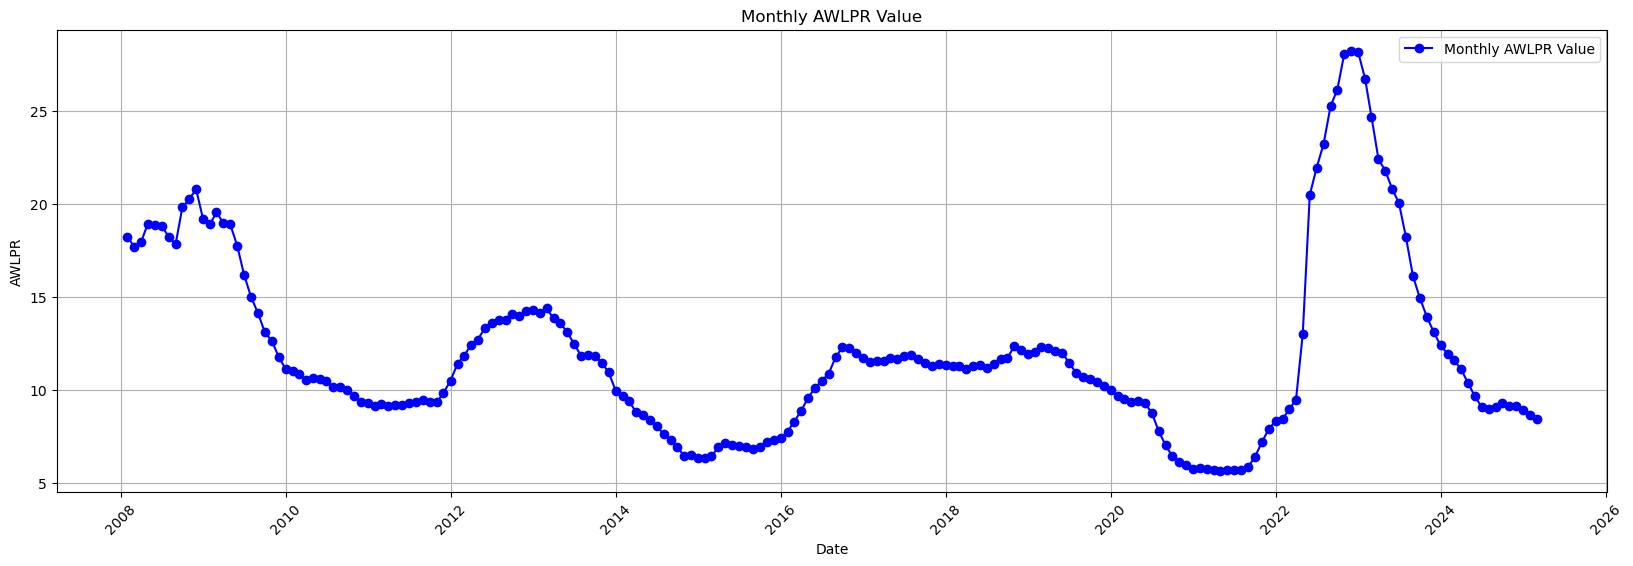

In [34]:

# Plot the sales trend over time
plt.figure(figsize=(20, 6))
plt.plot(df_adjusted_dates["Date"], df_adjusted_dates["Value"], marker='o', linestyle='-', color='b', label="Monthly AWLPR Value")

# Formatting the plot
plt.xlabel("Date")
plt.ylabel("AWLPR")
plt.title("Monthly AWLPR Value")
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.legend()
plt.grid()

# Show the plot
plt.show()

### Inflation Data

In [39]:
# Target URL
url = "https://www.cbsl.gov.lk/cbsl_custom/inflation/inflationwindow.php"

# Get the page content
headers = {"User-Agent": "Mozilla/5.0"}
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.content, "html.parser")

# Find the table
table = soup.find("table")

# Extract rows
data = []
for row in table.find_all("tr"):
    cells = row.find_all("td")
    row_data = [cell.get_text(strip=True) for cell in cells]
    if row_data:
        data.append(row_data)

# Convert to DataFrame
df = pd.DataFrame(data)

# Display DataFrame
df.to_csv("../data/inflation_data_2025_2023.csv", index=False)
print("Data saved to inflation_2025_2023.csv")


Data saved to inflation_2025_2023.csv


In [41]:

# Target URL
url = "https://www.cbsl.gov.lk/cbsl_custom/inflation/inflationwindow.php"

# Get the page content
headers = {"User-Agent": "Mozilla/5.0"}
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.content, "html.parser")

# Find all tables on the page
tables = soup.find_all("table")

# Extract data from both tables
data_tables = []
for table in tables:
    data = []
    for row in table.find_all("tr"):
        cells = row.find_all("td")
        row_data = [cell.get_text(strip=True) for cell in cells]
        if row_data:
            data.append(row_data)

    # Convert to DataFrame
    df_inflation = pd.DataFrame(data)
    data_tables.append(df_inflation)

# Display DataFrame
df_inflation.to_csv("../data/inflation_data_2022_2020.csv", index=False)
print("Data saved to inflation_data_2022_2020.csv")


Data saved to inflation_data_2022_2020.csv


In [45]:
# Load the CSV fil 2025-2023
df_2025 = pd.read_csv("../data/inflation_data_2025_2023.csv", header=None)  # Read without headers


# Drop the first two rows and reset the index
df_cleaned_2025 = df_2025.iloc[2:].reset_index(drop=True)

# Rename columns based on the second row (which had the headers)
df_cleaned_2025.columns = [
    "Date", "CCPI Headline Inflation(Y-o-Y)", "CCPI Core Inflation(Y-o-Y)", 
    "NCPI Headline Inflation(Y-o-Y)", "NCPI Core Inflation(Y-o-Y)"
]

# Drop rows where "Date" is NaN (previously metadata rows)
df_cleaned_2025 = df_cleaned_2025.dropna(subset=["Date"]).reset_index(drop=True)

# Identify the rows that indicate years
years = df_cleaned_2025[df_cleaned_2025["Date"].str.match(r"^\d{4}$", na=False)]

# Create a dictionary to store DataFrames for each year
dfs_by_year = {}

# Iterate through years and split data accordingly
previous_index = None
for index, row in years.iterrows():
    year = row["Date"]
    if previous_index is not None:
        dfs_by_year[previous_year] = df_cleaned_2025.iloc[previous_index:index].reset_index(drop=True)
    previous_index = index + 1
    previous_year = year

# Capture the last segment
if previous_index is not None:
    dfs_by_year[previous_year] = df_cleaned_2025.iloc[previous_index:].reset_index(drop=True)

In [47]:
# Assuming dfs_by_year is a dictionary with year keys and DataFrames as values
combined_dfs_2025 = []

for year, df_2025 in dfs_by_year.items():
    # Create a proper date string (YYYY-Month)
    df_2025 = df_2025.copy()  # Avoid modifying original dictionary
    df_2025['Date'] = year + '-' + df_2025['Date']

    # Convert 'Date' column to datetime format
    df_2025["Date_Converted"] = pd.to_datetime(df_2025["Date"], format='%Y-%B')

    # Generate a sortable ID in YYYYMM format
    df_2025["ID"] = df_2025["Date_Converted"].dt.year * 100 + df_2025["Date_Converted"].dt.month

    # Append processed DataFrame to list
    combined_dfs_2025.append(df_2025)

# Concatenate all DataFrames into one
combined_df_2025 = pd.concat(combined_dfs_2025, ignore_index=True)

# Sort everything from most recent to oldest
combined_df_2025 = combined_df_2025.sort_values(by="ID", ascending=False).drop(columns=["Date_Converted"])

# Display the combined DataFrame
print(combined_df_2025.head())

# Convert 'Date' column to end-of-month format
combined_df_2025['Date'] = pd.to_datetime(combined_df_2025['Date'], format='%Y-%B') + pd.offsets.MonthEnd(0)


# Display the combined DataFrame
print(combined_df_2025.head())

             Date CCPI Headline Inflation(Y-o-Y) CCPI Core Inflation(Y-o-Y)  \
1   2025-February                          -4.20                       0.70   
0    2025-January                          -4.00                       1.20   
13  2024-December                          -1.70                       2.70   
12  2024-November                          -2.10                       2.70   
11   2024-October                          -0.80                       3.00   

   NCPI Headline Inflation(Y-o-Y) NCPI Core Inflation(Y-o-Y)      ID  
1                               -                          -  202502  
0                           -4.00                      -0.20  202501  
13                          -2.00                       1.30  202412  
12                          -1.70                       1.50  202411  
11                          -0.70                       1.70  202410  
         Date CCPI Headline Inflation(Y-o-Y) CCPI Core Inflation(Y-o-Y)  \
1  2025-02-28           

In [51]:
# Load the CSV file 2022-2020
df_2022 = pd.read_csv("../data/inflation_data_2022_2020.csv", header=None)  # Read without headers


# Drop the first two rows and reset the index
df_cleaned_2022 = df_2022.iloc[2:].reset_index(drop=True)

# Rename columns based on the second row (which had the headers)
df_cleaned_2022.columns = [
    "Date", "CCPI Headline Inflation(Y-o-Y)", "CCPI Core Inflation(Y-o-Y)", 
    "NCPI Headline Inflation(Y-o-Y)", "NCPI Core Inflation(Y-o-Y)"
]


# Drop rows where "Date" is NaN (previously metadata rows)
df_cleaned_2022 = df_cleaned_2022.dropna(subset=["Date"]).reset_index(drop=True)

# Identify the rows that indicate years
years = df_cleaned_2022[df_cleaned_2022["Date"].str.match(r"^\d{4}$", na=False)]

# Create a dictionary to store DataFrames for each year
dfs_by_year = {}

# Iterate through years and split data accordingly
previous_index = None
for index, row in years.iterrows():
    year = row["Date"]
    if previous_index is not None:
        dfs_by_year[previous_year] = df_cleaned_2022.iloc[previous_index:index].reset_index(drop=True)
    previous_index = index + 1
    previous_year = year

# Capture the last segment
if previous_index is not None:
    dfs_by_year[previous_year] = df_cleaned_2022.iloc[previous_index:].reset_index(drop=True)

In [54]:
# Assuming dfs_by_year is a dictionary with year keys and DataFrames as values
combined_dfs_2022 = []

for year, df_2022 in dfs_by_year.items():
    # Create a proper date string (YYYY-Month)
    df_2022 = df_2022.copy()  # Avoid modifying original dictionary
    df_2022['Date'] = year + '-' + df_2022['Date']

    # Convert 'Date' column to datetime format
    df_2022["Date_Converted"] = pd.to_datetime(df_2022["Date"], format='%Y-%B')

    # Generate a sortable ID in YYYYMM format
    df_2022["ID"] = df_2022["Date_Converted"].dt.year * 100 + df_2022["Date_Converted"].dt.month

    # Append processed DataFrame to list
    combined_dfs_2022.append(df_2022)

# Concatenate all DataFrames into one
combined_df_2022 = pd.concat(combined_dfs_2022, ignore_index=True)

# Sort everything from most recent to oldest
combined_df_2022 = combined_df_2022.sort_values(by="ID", ascending=False).drop(columns=["Date_Converted"])

# Convert 'Date' column to end-of-month format
combined_df_2022['Date'] = pd.to_datetime(combined_df_2022['Date'], format='%Y-%B') + pd.offsets.MonthEnd(0)


# Display the combined DataFrame
print(combined_df_2022.head(10))



         Date CCPI Headline Inflation(Y-o-Y) CCPI Core Inflation(Y-o-Y)  \
11 2022-12-31                          57.20                      47.70   
10 2022-11-30                          61.00                      49.40   
9  2022-10-31                          66.00                      49.70   
8  2022-09-30                          69.80                      50.20   
7  2022-08-31                          64.30                      46.60   
6  2022-07-31                          60.80                      44.30   
5  2022-06-30                          54.60                      39.90   
4  2022-05-31                          39.10                      28.40   
3  2022-04-30                          29.80                      22.00   
2  2022-03-31                          18.70                      13.00   

   NCPI Headline Inflation(Y-o-Y) NCPI Core Inflation(Y-o-Y)      ID  
11                          59.20                      57.50  202212  
10                          65.0

In [56]:
print(combined_df_2025.head(1))
print(combined_df_2022.tail(1))

        Date CCPI Headline Inflation(Y-o-Y) CCPI Core Inflation(Y-o-Y)  \
1 2025-02-28                          -4.20                       0.70   

  NCPI Headline Inflation(Y-o-Y) NCPI Core Inflation(Y-o-Y)      ID  
1                              -                          -  202502  
         Date CCPI Headline Inflation(Y-o-Y) CCPI Core Inflation(Y-o-Y)  \
24 2020-01-31                           5.70                       3.00   

   NCPI Headline Inflation(Y-o-Y) NCPI Core Inflation(Y-o-Y)      ID  
24                           7.60                       3.90  202001  


In [58]:
# Combine the two dataframes
inflation_data_till_2020 = pd.concat([combined_df_2025, combined_df_2022], ignore_index=True)


# Define the output directory and filename
output_dir = "../data"
output_file = os.path.join(output_dir, "inflation_data_till_2020.csv")

# Ensure the directory exists
os.makedirs(output_dir, exist_ok=True)

# Save the combined data to CSV
inflation_data_till_2020.to_csv(output_file, index=False)

print(f"Combined data saved to: {output_file}")

Combined data saved to: ../data/inflation_data_till_2020.csv


In [60]:
print(inflation_data_till_2020.shape)
# Save to file
df_inflation.to_csv("../data/inflation_data_till_2020.csv", index=False)
print("Data saved to inflation_data_till_2020.csv")


(62, 6)
Data saved to inflation_data_till_2020.csv


In [62]:
print(inflation_data_till_2020.head(10))
print(inflation_data_till_2020.tail(10))

        Date CCPI Headline Inflation(Y-o-Y) CCPI Core Inflation(Y-o-Y)  \
0 2025-02-28                          -4.20                       0.70   
1 2025-01-31                          -4.00                       1.20   
2 2024-12-31                          -1.70                       2.70   
3 2024-11-30                          -2.10                       2.70   
4 2024-10-31                          -0.80                       3.00   
5 2024-09-30                          -0.50                       3.30   
6 2024-08-31                           0.50                       3.60   
7 2024-07-31                           2.40                       4.40   
8 2024-06-30                           1.70                       4.40   
9 2024-05-31                           0.90                       3.50   

  NCPI Headline Inflation(Y-o-Y) NCPI Core Inflation(Y-o-Y)      ID  
0                              -                          -  202502  
1                          -4.00             

### Concat inflation data and AWLPR data into one data frame

In [65]:
# filter AWLPR dates to match with inflation date range
# Define the date range
start_date = pd.Timestamp("2020-01-31")
end_date = pd.Timestamp("2025-02-28")

# Filter the DataFrame to include only rows within the specified date range
awplr_data_till_2020 = df_adjusted_dates[(df_adjusted_dates["Date"] >= start_date) & (df_adjusted_dates["Date"] <= end_date)]


In [67]:
print(awplr_data_till_2020)

# Save to file
df_inflation.to_csv("../data/awplr_data_till_2020.csv", index=False)
print("Data saved to awplr_data_till_2020.csv")

          Date  Value
0   2025-02-28   8.45
4   2025-01-31   8.66
8   2024-12-31   8.92
14  2024-11-30   9.11
18  2024-10-31   9.14
..         ...    ...
281 2020-05-31   9.28
285 2020-04-30   9.38
289 2020-03-31   9.35
295 2020-02-29   9.51
299 2020-01-31   9.68

[62 rows x 2 columns]
Data saved to awplr_data_till_2020.csv


In [69]:
# Define a dictionary for renaming columns
rename_dict = {
    "CCPI Headline Inflation(Y-o-Y)": "CCPI_Headline",
    "CCPI Core Inflation(Y-o-Y)": "CCPI_Core",
    "NCPI Headline Inflation(Y-o-Y)": "NCPI_Headline",
    "NCPI Core Inflation(Y-o-Y)": "NCPI_Core"
}

# Select and rename columns from inflation_data_till_2020
inflation_selected = inflation_data_till_2020[list(rename_dict.keys())].rename(columns=rename_dict)
awplr_data_till_2020 = awplr_data_till_2020.rename(columns={"Value": "AWPLR"})


# Reset index to avoid misalignment
awplr_data_till_2020 = awplr_data_till_2020.reset_index(drop=True)
inflation_selected = inflation_selected.reset_index(drop=True)

# Concatenate column-wise
awplr_inflation_data = pd.concat([awplr_data_till_2020, inflation_selected], axis=1)

print(awplr_inflation_data)

         Date  AWPLR CCPI_Headline CCPI_Core NCPI_Headline NCPI_Core
0  2025-02-28   8.45         -4.20      0.70             -         -
1  2025-01-31   8.66         -4.00      1.20         -4.00     -0.20
2  2024-12-31   8.92         -1.70      2.70         -2.00      1.30
3  2024-11-30   9.11         -2.10      2.70         -1.70      1.50
4  2024-10-31   9.14         -0.80      3.00         -0.70      1.70
..        ...    ...           ...       ...           ...       ...
57 2020-05-31   9.28          4.00      2.90          5.20      3.70
58 2020-04-30   9.38          5.20      3.10          5.90      3.20
59 2020-03-31   9.35          5.40      2.90          7.00      3.20
60 2020-02-29   9.51          6.20      3.20          8.10      3.40
61 2020-01-31   9.68          5.70      3.00          7.60      3.90

[62 rows x 6 columns]


In [83]:
import numpy as np

# use forward fill to fill out - values
# Replace "-" with NaN for NCPI_Headline and NCPI_Core
awplr_inflation_data[["NCPI_Headline", "NCPI_Core"]] = (
    awplr_inflation_data[["NCPI_Headline", "NCPI_Core"]]
    .replace("-", np.nan)
    .astype(float)
)

# List of columns to convert to numeric
numeric_columns = ["AWPLR", "CCPI_Headline", "CCPI_Core", "NCPI_Headline", "NCPI_Core"]

# Convert selected columns to numeric, coercing errors to NaN
awplr_inflation_data[numeric_columns] = awplr_inflation_data[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Apply forward fill to fill missing values
awplr_inflation_data[numeric_columns] = awplr_inflation_data[numeric_columns].bfill()

print(awplr_inflation_data)


         Date  AWPLR  CCPI_Headline  CCPI_Core  NCPI_Headline  NCPI_Core
0  2025-02-28   8.45           -4.2        0.7           -4.0       -0.2
1  2025-01-31   8.66           -4.0        1.2           -4.0       -0.2
2  2024-12-31   8.92           -1.7        2.7           -2.0        1.3
3  2024-11-30   9.11           -2.1        2.7           -1.7        1.5
4  2024-10-31   9.14           -0.8        3.0           -0.7        1.7
..        ...    ...            ...        ...            ...        ...
57 2020-05-31   9.28            4.0        2.9            5.2        3.7
58 2020-04-30   9.38            5.2        3.1            5.9        3.2
59 2020-03-31   9.35            5.4        2.9            7.0        3.2
60 2020-02-29   9.51            6.2        3.2            8.1        3.4
61 2020-01-31   9.68            5.7        3.0            7.6        3.9

[62 rows x 6 columns]


In [85]:
# Save to file
awplr_inflation_data.to_csv("../data/awplr_inflation_data_till_2020.csv", index=False)
print("Data saved to awplr_inflation_data_till_2020.csv")

Data saved to awplr_inflation_data_till_2020.csv


### EDA

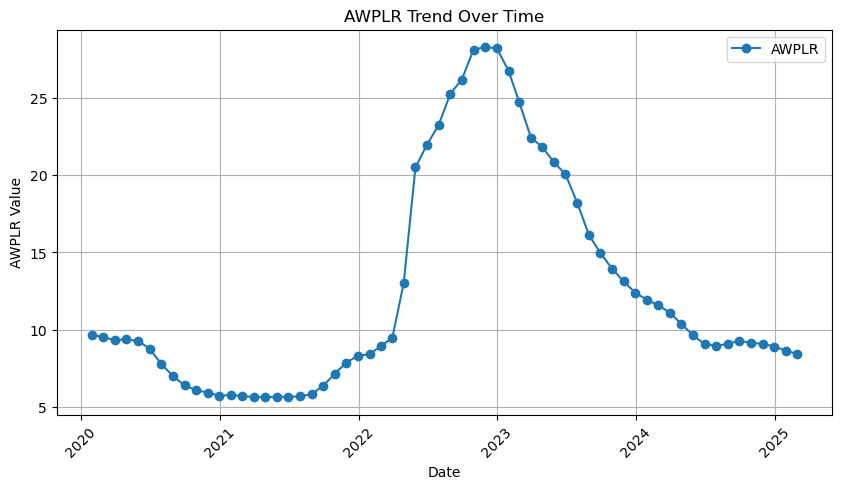

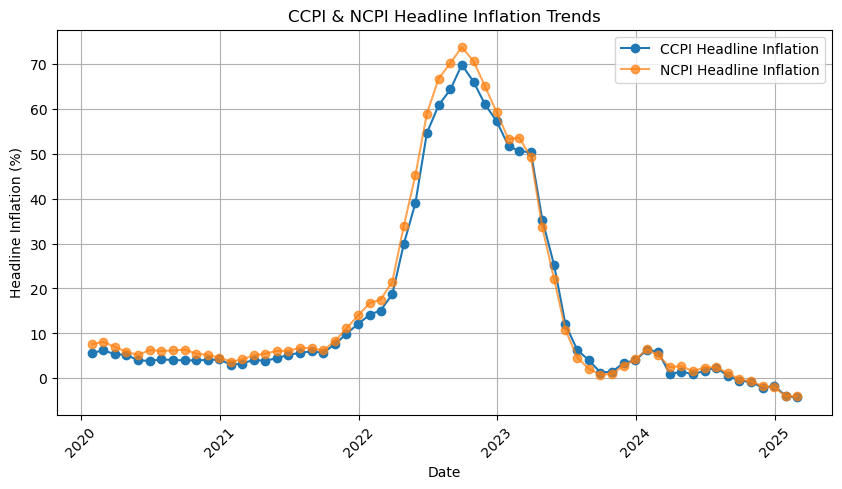

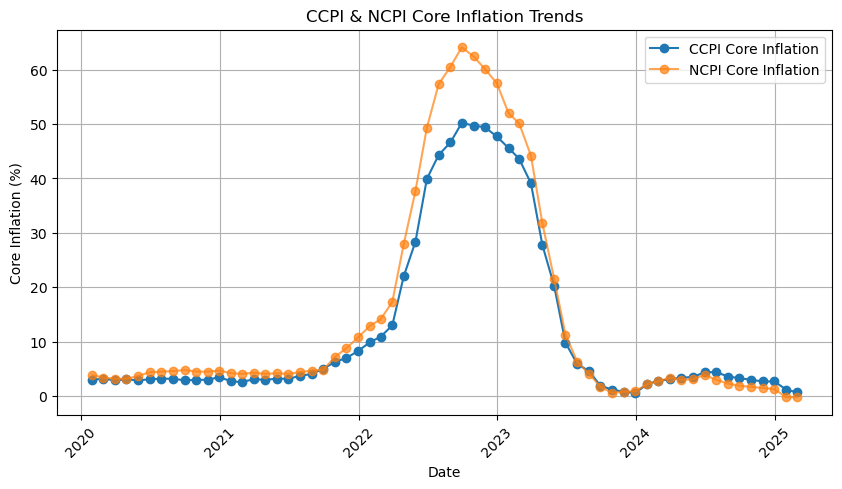

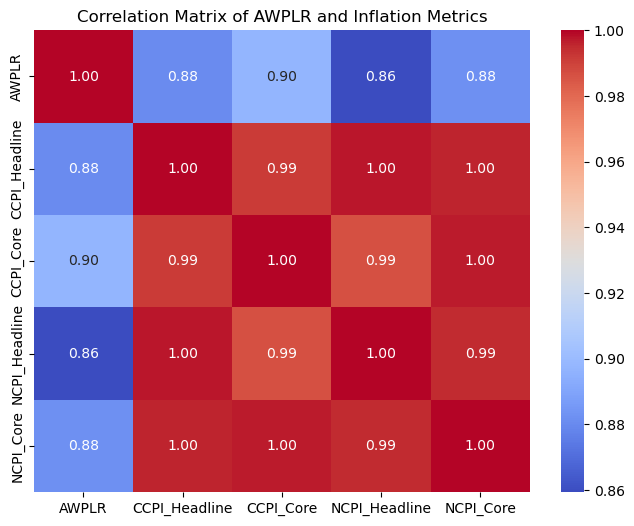

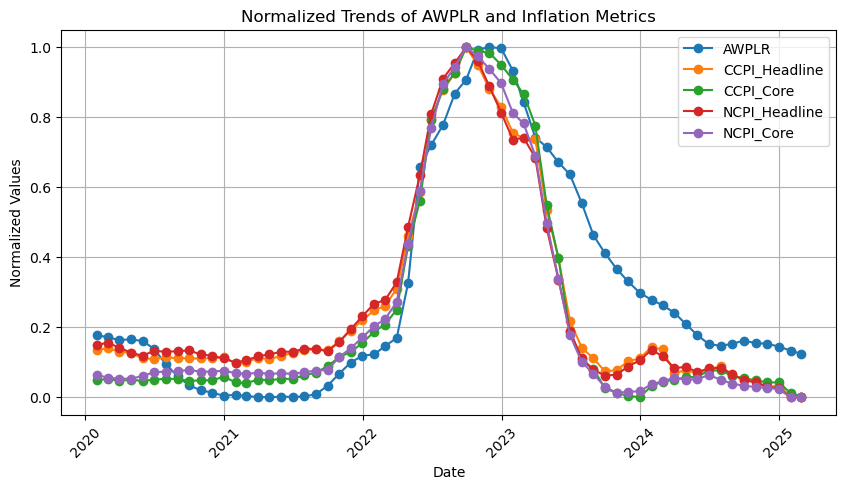

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Ensure Date column is in datetime format
awplr_inflation_data["Date"] = pd.to_datetime(awplr_inflation_data["Date"])

# Normalize the data for better visualization (excluding Date column)
scaler = MinMaxScaler()
normalized_data = awplr_inflation_data.copy()
normalized_data[["AWPLR", "CCPI_Headline", "CCPI_Core", "NCPI_Headline", "NCPI_Core"]] = scaler.fit_transform(
    awplr_inflation_data[["AWPLR", "CCPI_Headline", "CCPI_Core", "NCPI_Headline", "NCPI_Core"]])

# Plot 1: AWPLR Trend Over Time
plt.figure(figsize=(10, 5))
plt.plot(awplr_inflation_data["Date"], awplr_inflation_data["AWPLR"], marker='o', linestyle='-', label="AWPLR")
plt.xlabel("Date")
plt.ylabel("AWPLR Value")
plt.title("AWPLR Trend Over Time")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

# Plot 2: Headline Inflation Trends (CCPI and NCPI)
plt.figure(figsize=(10, 5))
plt.plot(awplr_inflation_data["Date"], awplr_inflation_data["CCPI_Headline"], marker='o', linestyle='-', label="CCPI Headline Inflation")
plt.plot(awplr_inflation_data["Date"], awplr_inflation_data["NCPI_Headline"], marker='o', linestyle='-', label="NCPI Headline Inflation", alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Headline Inflation (%)")
plt.title("CCPI & NCPI Headline Inflation Trends")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

# Plot 3: Core Inflation Trends (CCPI and NCPI)
plt.figure(figsize=(10, 5))
plt.plot(awplr_inflation_data["Date"], awplr_inflation_data["CCPI_Core"], marker='o', linestyle='-', label="CCPI Core Inflation")
plt.plot(awplr_inflation_data["Date"], awplr_inflation_data["NCPI_Core"], marker='o', linestyle='-', label="NCPI Core Inflation", alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Core Inflation (%)")
plt.title("CCPI & NCPI Core Inflation Trends")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

# Plot 4: Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(awplr_inflation_data[["AWPLR", "CCPI_Headline", "CCPI_Core", "NCPI_Headline", "NCPI_Core"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of AWPLR and Inflation Metrics")
plt.show()

# Plot 5: Normalized Trends for Comparison
plt.figure(figsize=(10, 5))
for col in ["AWPLR", "CCPI_Headline", "CCPI_Core", "NCPI_Headline", "NCPI_Core"]:
    plt.plot(normalized_data["Date"], normalized_data[col], marker='o', linestyle='-', label=col)
plt.xlabel("Date")
plt.ylabel("Normalized Values")
plt.title("Normalized Trends of AWPLR and Inflation Metrics")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()
